In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-9x2l9shb
  Running command git clone --filter=blob:none --quiet https://github.com/deepvision-class/starter-code /tmp/pip-req-build-9x2l9shb
  Resolved https://github.com/deepvision-class/starter-code to commit e8d9fe711870a39796a2f8ad95538e57942d756f
  Preparing metadata (setup.py) ... done
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10297 sha256=b6dc91a71e2e885580d6ddc202c0f5d65adfc16d858321b115f2777273df0285
  Stored in directory: /tmp/pip-ephem-wheel-cache-7qtewsi_/wheels/c2/e7/85/d06d934df58ee176009a1b34feb38efbc9ab4e13ee469b2618
Successfully built Colab-Utils


In [2]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
# import coutils
# from coutils import fix_random_seed, rel_error

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
# import coutils
# from coutils import extract_drive_file_id, register_colab_notebooks, \
#                     fix_random_seed, rel_error
import matplotlib.pyplot as plt
import numpy as np
import cv2
import copy
import time
import shutil
import os

# parameters for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
# unpack as argument to torch functions, like so: **to_float
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

# for mAP evaluation
!rm -rf mAP
!git clone https://github.com/Cartucho/mAP.git
!rm -rf mAP/input/*

Cloning into 'mAP'...
remote: Enumerating objects: 908, done.
remote: Total 908 (delta 0), reused 0 (delta 0), pack-reused 908
Receiving objects: 100% (908/908), 14.71 MiB | 5.42 MiB/s, done.
Resolving deltas: 100% (321/321), done.


In [3]:
if torch.cuda.is_available():
    print('Good to go!')
else:
    print('Please set GPU via Edit -> Notebook Settings.')

Please set GPU via Edit -> Notebook Settings.


In [4]:
def get_pascal_voc2007_data(image_root, split='train'):
    """
    Use torchvision.datasets
    https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.VOCDetection
    """
    from torchvision import datasets

    train_dataset = datasets.VOCDetection(image_root, year='2007', image_set=split,
                                    download=True)

    return train_dataset

In [5]:
# uncomment below to use the mirror link if the original link is broken
# !wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
!wget https://www.eecs.umich.edu/courses/eecs442-ahowens/fa20/pascal_voc/VOCtrainval_06-Nov-2007.tar

--2023-04-26 21:13:38--  https://www.eecs.umich.edu/courses/eecs442-ahowens/fa20/pascal_voc/VOCtrainval_06-Nov-2007.tar
Resolving www.eecs.umich.edu... 141.212.113.199
Connecting to www.eecs.umich.edu|141.212.113.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: 'VOCtrainval_06-Nov-2007.tar'

VOCtrainval_06-Nov- 100%[===================>] 438.72M  5.44MB/s    in 98s     

2023-04-26 21:15:16 (4.50 MB/s) - 'VOCtrainval_06-Nov-2007.tar' saved [460032000/460032000]



In [6]:
!ls -l
!chmod -R 777 content
!ls -l

total 942696
-rw-r--r--  1 pleple  staff  460032000 Oct 21  2020 VOCtrainval_06-Nov-2007.tar
-rw-r--r--@ 1 pleple  staff    1246948 Apr 26 21:14 YOLOv3.ipynb
-rw-r--r--  1 pleple  staff    1247064 Apr 26 21:09 YOLOv3_inference.ipynb
drwxr-xr-x  9 pleple  staff        288 Apr 26 21:11 mAP
-rw-r--r--  1 pleple  staff    9822781 Apr 18 17:14 yolo_detector.pt
chmod: content: No such file or directory
total 942696
-rw-r--r--  1 pleple  staff  460032000 Oct 21  2020 VOCtrainval_06-Nov-2007.tar
-rw-r--r--@ 1 pleple  staff    1246948 Apr 26 21:14 YOLOv3.ipynb
-rw-r--r--  1 pleple  staff    1247064 Apr 26 21:09 YOLOv3_inference.ipynb
drwxr-xr-x  9 pleple  staff        288 Apr 26 21:11 mAP
-rw-r--r--  1 pleple  staff    9822781 Apr 18 17:14 yolo_detector.pt


In [48]:
train_dataset = get_pascal_voc2007_data('content', 'train')
val_dataset = get_pascal_voc2007_data('content', 'val')
# an example on the raw annotation
import json
print("============== Raw Annotation Example ==============")
print(json.dumps(train_dataset[1][1]['annotation'], indent=2))

Using downloaded and verified file: content/VOCtrainval_06-Nov-2007.tar
Extracting content/VOCtrainval_06-Nov-2007.tar to content
Using downloaded and verified file: content/VOCtrainval_06-Nov-2007.tar
Extracting content/VOCtrainval_06-Nov-2007.tar to content
============== Raw Annotation Example ==============
{
  "folder": "VOC2007",
  "filename": "000017.jpg",
  "source": {
    "database": "The VOC2007 Database",
    "annotation": "PASCAL VOC2007",
    "image": "flickr",
    "flickrid": "228217974"
  },
  "owner": {
    "flickrid": "genewolf",
    "name": "whiskey kitten"
  },
  "size": {
    "width": "480",
    "height": "364",
    "depth": "3"
  },
  "segmented": "0",
  "object": [
    {
      "name": "person",
      "pose": "Left",
      "truncated": "0",
      "difficult": "0",
      "bndbox": {
        "xmin": "185",
        "ymin": "62",
        "xmax": "279",
        "ymax": "199"
      }
    },
    {
      "name": "horse",
      "pose": "Left",
      "truncated": "0",
      

In [16]:
def pascal_voc2007_loader(dataset, batch_size, num_workers=0):
    """
    Data loader for Pascal VOC 2007.
    https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
    """
    from torch.utils.data import DataLoader
    # turn off shuffle so we can index the original image
    loader = DataLoader(dataset,
                          batch_size=batch_size,
                          shuffle=False, pin_memory=True,
                          num_workers=num_workers,
                          collate_fn=voc_collate_fn)
    return loader


class_to_idx = {'aeroplane':0, 'bicycle':1, 'bird':2, 'boat':3, 'bottle':4,
                'bus':5, 'car':6, 'cat':7, 'chair':8, 'cow':9, 'diningtable':10,
                'dog':11, 'horse':12, 'motorbike':13, 'person':14, 'pottedplant':15,
                'sheep':16, 'sofa':17, 'train':18, 'tvmonitor':19
}
idx_to_class = {i:c for c, i in class_to_idx.items()}

from torchvision import transforms

def voc_collate_fn(batch_lst, reshape_size=224):
    preprocess = transforms.Compose([
      transforms.Resize((reshape_size, reshape_size)),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
      ])
    
    batch_size = len(batch_lst)
    
    img_batch = torch.zeros(batch_size, 3, reshape_size, reshape_size)
    
    max_num_box = max(len(batch_lst[i][1]['annotation']['object']) \
                      for i in range(batch_size))

    box_batch = torch.Tensor(batch_size, max_num_box, 5).fill_(-1.)
    w_list = []
    h_list = []
    img_id_list = []
    
    for i in range(batch_size):
        img, ann = batch_lst[i]
        w_list.append(img.size[0]) # image width
        h_list.append(img.size[1]) # image height
        img_id_list.append(ann['annotation']['filename'])
        img_batch[i] = preprocess(img)
        all_bbox = ann['annotation']['object']
        if type(all_bbox) == dict: # inconsistency in the annotation file
            all_bbox = [all_bbox]
        
        for bbox_idx, one_bbox in enumerate(all_bbox):
            bbox = one_bbox['bndbox']
            obj_cls = one_bbox['name']
            box_batch[i][bbox_idx] = torch.Tensor([float(bbox['xmin']), float(bbox['ymin']),
              float(bbox['xmax']), float(bbox['ymax']), class_to_idx[obj_cls]])
            box_idx += 1
    
    h_batch = torch.tensor(h_list)
    w_batch = torch.tensor(w_list)

    return img_batch, box_batch, w_batch, h_batch, img_id_list

In [53]:
def filter_dataset_with_class(dataset, class_name, ratio):
    images_with_class = []
    images_without_class = []
    final_images = []
    for img, ann in dataset:
        objects = ann['annotation']['object']
        if type(objects) == dict:
            objects = [objects]
        names = [obj['name'] for obj in objects]
        if class_name in names:
            images_with_class.append((img, ann))
        else:
            images_without_class.append((img, ann))
    target_num = len(images_with_class)
    non_target_num = len(images_without_class)
    cur_ratio = target_num / (target_num + non_target_num)
    if ratio > cur_ratio:
        final_images.extend(images_with_class)
        final_images.extend(random.sample(images_without_class, int((1 - ratio) / ratio * target_num)))
    else:
        final_images.extend(images_without_class)
        final_images.extend(random.sample(images_with_class, int(ratio / (1 - ratio) * non_target_num)))
    random.shuffle(final_images)
    return final_images

In [55]:
train_dataset = torch.utils.data.Subset(train_dataset, torch.arange(0, 2500)) # use 2500 samples for training

In [56]:
train_dataset_cat = filter_dataset_with_class(train_dataset, 'cat', 0.2)

In [57]:
train_loader = pascal_voc2007_loader(train_dataset_cat, 10)
val_loader = pascal_voc2007_loader(val_dataset, 10)

In [61]:
train_loader_iter = iter(train_loader)
img, ann, _, _, _ = next(train_loader_iter)


print('img has shape: ', img.shape)
print('ann has shape: ', ann.shape)

print('Image 1 has only two annotated objects, so ann[1] is padded with -1:')
print(ann[1])

print('\nImage 2 has six annotated objects:, so ann[2] is not padded:')
print(ann[2])

print('\nEach row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).')

img has shape:  torch.Size([10, 3, 224, 224])
ann has shape:  torch.Size([10, 6, 5])
Image 1 has only two annotated objects, so ann[1] is padded with -1:
tensor([[ 12.,  60., 500., 307.,   6.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])

Image 2 has six annotated objects:, so ann[2] is not padded:
tensor([[129., 161., 150., 201.,  14.],
        [  8.,  10., 500., 221.,  18.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.],
        [ -1.,  -1.,  -1.,  -1.,  -1.]])

Each row in the annotation tensor indicates (x_tl, y_tl, x_br, y_br, class).


In [ ]:
def coord_trans(bbox, w_pixel, h_pixel, w_amap=7, h_amap=7, mode='a2p'):
    """
    Coordinate transformation function. It converts the box coordinate from
    the image coordinate system to the activation map coordinate system and vice versa.
    In our case, the input image will have a few hundred pixels in
    width/height while the activation map is of size 7x7.

    Input:
    - bbox: Could be either bbox, anchor, or proposal, of shape Bx*x4
    - w_pixel: Number of pixels in the width side of the original image, of shape B
    - h_pixel: Number of pixels in the height side of the original image, of shape B
    - w_amap: Number of pixels in the width side of the activation map, scalar
    - h_amap: Number of pixels in the height side of the activation map, scalar
    - mode: Whether transfer from the original image to activation map ('p2a') or
          the opposite ('a2p')

    Output:
    - resized_bbox: Resized box coordinates, of the same shape as the input bbox
    """

    assert mode in ('p2a', 'a2p'), 'invalid coordinate transformation mode!'
    assert bbox.shape[-1] >= 4, 'the transformation is applied to the first 4 values of dim -1'

    if bbox.shape[0] == 0: # corner cases
        return bbox

    resized_bbox = bbox.clone()
    # could still work if the first dim of bbox is not batch size
    # in that case, w_pixel and h_pixel will be scalars
    resized_bbox = resized_bbox.view(bbox.shape[0], -1, bbox.shape[-1])
    invalid_bbox_mask = (resized_bbox == -1) # indicating invalid bbox

    if mode == 'p2a':
        # pixel to activation
        width_ratio = w_pixel * 1. / w_amap
        height_ratio = h_pixel * 1. / h_amap
        resized_bbox[:, :, [0, 2]] /= width_ratio.view(-1, 1, 1)
        resized_bbox[:, :, [1, 3]] /= height_ratio.view(-1, 1, 1)
    else:
        # activation to pixel
        width_ratio = w_pixel * 1. / w_amap
        height_ratio = h_pixel * 1. / h_amap
        resized_bbox[:, :, [0, 2]] *= width_ratio.view(-1, 1, 1)
        resized_bbox[:, :, [1, 3]] *= height_ratio.view(-1, 1, 1)

    resized_bbox.masked_fill_(invalid_bbox_mask, -1)
    resized_bbox.resize_as_(bbox)
    return resized_bbox

In [ ]:
def data_visualizer(img, idx_to_class, bbox=None, pred=None):
    """
    Data visualizer on the original image. Support both GT box input and proposal 
    input.

    Input:
    - img: PIL Image input
    - idx_to_class: Mapping from the index (0-19) to the class name
    - bbox: GT bbox (in red, optional), a tensor of shape Nx5, where N is
          the number of GT boxes, 5 indicates (x_tl, y_tl, x_br, y_br, class)
    - pred: Predicted bbox (in green, optional), a tensor of shape N'x6, where
          N' is the number of predicted boxes, 6 indicates
          (x_tl, y_tl, x_br, y_br, class, object confidence score)
    """

    img_copy = np.array(img).astype('uint8')

    if bbox is not None:
        for bbox_idx in range(bbox.shape[0]):
            one_bbox = bbox[bbox_idx][:4]
            cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]),
                      int(one_bbox[3])), (255, 0, 0), 2)
            if bbox.shape[1] > 4: # if class info provided
                obj_cls = idx_to_class[bbox[bbox_idx][4].item()]
                cv2.putText(img_copy, '%s' % (obj_cls),
                          (one_bbox[0], one_bbox[1]+15),
                          cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

    if pred is not None:
        for bbox_idx in range(pred.shape[0]):
            one_bbox = pred[bbox_idx][:4]
            cv2.rectangle(img_copy, (int(one_bbox[0]), int(one_bbox[1])), (int(one_bbox[2]),
                      int(one_bbox[3])), (0, 255, 0), 2)

            if pred.shape[1] > 4: # if class and conf score info provided
                obj_cls = idx_to_class[pred[bbox_idx][4].item()]
                conf_score = pred[bbox_idx][5].item()
                cv2.putText(img_copy, '%s, %.2f' % (obj_cls, conf_score),
                            (one_bbox[0], one_bbox[1]+15),
                            cv2.FONT_HERSHEY_PLAIN, 1.0, (0, 0, 255), thickness=1)

    plt.imshow(img_copy)
    plt.axis('off')
    plt.show()

In [ ]:
import random
def fix_random_seed(seed_no=0):
    """
    Fix random seed to get a deterministic output
    Inputs:
    - seed_no: seed number to be fixed
    """
    torch.manual_seed(seed_no)
    torch.cuda.manual_seed(seed_no)
    random.seed(seed_no)

In [ ]:
# default examples for visualization
fix_random_seed(1)
batch_size = 3
sampled_idx = torch.linspace(0, len(train_dataset)-1, steps=batch_size).long()

# get the size of each image first
h_list = []
w_list = []
img_list = [] # list of images
MAX_NUM_BBOX = 40
box_list = torch.LongTensor(batch_size, MAX_NUM_BBOX, 5).fill_(-1) # PADDED GT boxes

for idx, i in enumerate(sampled_idx):
    # hack to get the original image so we don't have to load from local again...
    img, ann = train_dataset.__getitem__(i)
    img_list.append(img)

    all_bbox = ann['annotation']['object']
    if type(all_bbox) == dict:
        all_bbox = [all_bbox]
    for bbox_idx, one_bbox in enumerate(all_bbox):
        bbox = one_bbox['bndbox']
        obj_cls = one_bbox['name']
        box_list[idx][bbox_idx] = torch.LongTensor([int(bbox['xmin']), int(bbox['ymin']),
          int(bbox['xmax']), int(bbox['ymax']), class_to_idx[obj_cls]])

    # get sizes
    img = np.array(img)
    w_list.append(img.shape[1])
    h_list.append(img.shape[0])

# w_list = torch.as_tensor(w_list, **to_float_cuda)
# h_list = torch.as_tensor(h_list, **to_float_cuda)
# box_list = torch.as_tensor(box_list, **to_float_cuda)
w_list = torch.as_tensor(w_list, **to_float)
h_list = torch.as_tensor(h_list, **to_float)
box_list = torch.as_tensor(box_list, **to_float)
resized_box_list = coord_trans(box_list, w_list, h_list, mode='p2a') # on activation map coordinate system

In [ ]:
# visualize GT boxes
for i in range(len(img_list)):
    valid_box = sum([1 if j != -1 else 0 for j in box_list[i][:, 0]])
    data_visualizer(img_list[i], idx_to_class, box_list[i][:valid_box])

error: OpenCV(4.7.0) :-1: error: (-5:Bad argument) in function 'putText'
> Overload resolution failed:
>  - Can't parse 'org'. Sequence item with index 0 has a wrong type
>  - Can't parse 'org'. Sequence item with index 0 has a wrong type


In [ ]:
class FeatureExtractor(nn.Module):
    """
    Image feature extraction with MobileNet.
    """
    def __init__(self, reshape_size=224, pooling=False, verbose=False):
        super().__init__()

        from torchvision import models
        from torchsummary import summary

        self.mobilenet = models.mobilenet_v2(pretrained=True)
        self.mobilenet = nn.Sequential(*list(self.mobilenet.children())[:-1]) # Remove the last classifier

        # average pooling
        if pooling:
            self.mobilenet.add_module('LastAvgPool', nn.AvgPool2d(math.ceil(reshape_size/32.))) # input: N x 1280 x 7 x 7

        for i in self.mobilenet.named_parameters():
            i[1].requires_grad = True # fine-tune all parameters

        if verbose:
            summary(self.mobilenet.cuda(), (3, reshape_size, reshape_size))

    def forward(self, img, verbose=False):
        """
        Inputs:
        - img: Batch of resized images, of shape Nx3x224x224

        Outputs:
        - feat: Image feature, of shape Nx1280 (pooled) or Nx1280x7x7
        """
        num_img = img.shape[0]

        img_prepro = img

        feat = []
        process_batch = 500
        for b in range(math.ceil(num_img/process_batch)):
            feat.append(self.mobilenet(img_prepro[b*process_batch:(b+1)*process_batch]
                                  ).squeeze(-1).squeeze(-1)) # forward and squeeze
        feat = torch.cat(feat)

        if verbose:
            print('Output feature shape: ', feat.shape)

        return feat

In [ ]:
pip install torch-summary


[notice] A new release of pip is available: 23.0.1 -> 23.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
model = FeatureExtractor(verbose=True)

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
# def GenerateGrid(batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cuda'):
def GenerateGrid(batch_size, w_amap=7, h_amap=7, dtype=torch.float32, device='cpu'):
    """
    Return a grid cell given a batch size (center coordinates).

    Inputs:
    - batch_size, B
    - w_amap: or W', width of the activation map (number of grids in the horizontal dimension)
    - h_amap: or H', height of the activation map (number of grids in the vertical dimension)
    - W' and H' are always 7 in our case while w and h might vary.

    Outputs:
    grid: A float32 tensor of shape (B, H', W', 2) giving the (x, y) coordinates
        of the centers of each feature for a feature map of shape (B, D, H', W')
    """
    w_range = torch.arange(0, w_amap, dtype=dtype, device=device) + 0.5
    h_range = torch.arange(0, h_amap, dtype=dtype, device=device) + 0.5

    w_grid_idx = w_range.unsqueeze(0).repeat(h_amap, 1)
    h_grid_idx = h_range.unsqueeze(1).repeat(1, w_amap)
    grid = torch.stack([w_grid_idx, h_grid_idx], dim=-1)
    grid = grid.unsqueeze(0).repeat(batch_size, 1, 1, 1)

    return grid

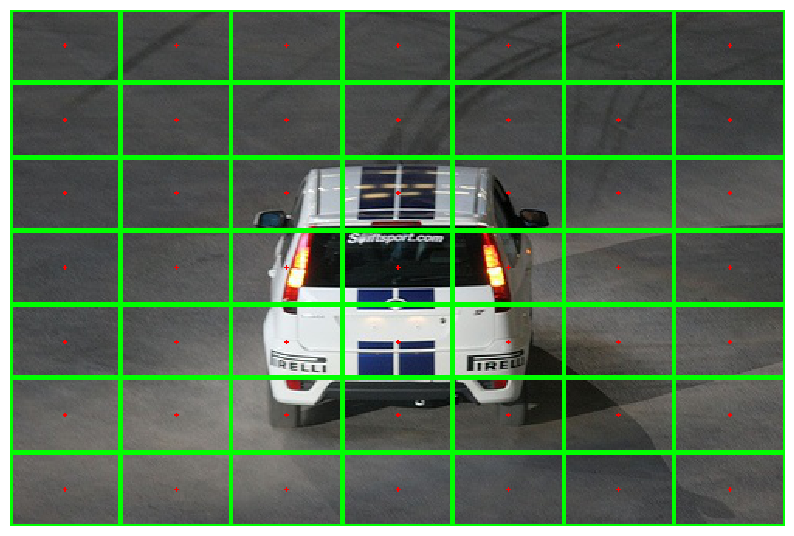

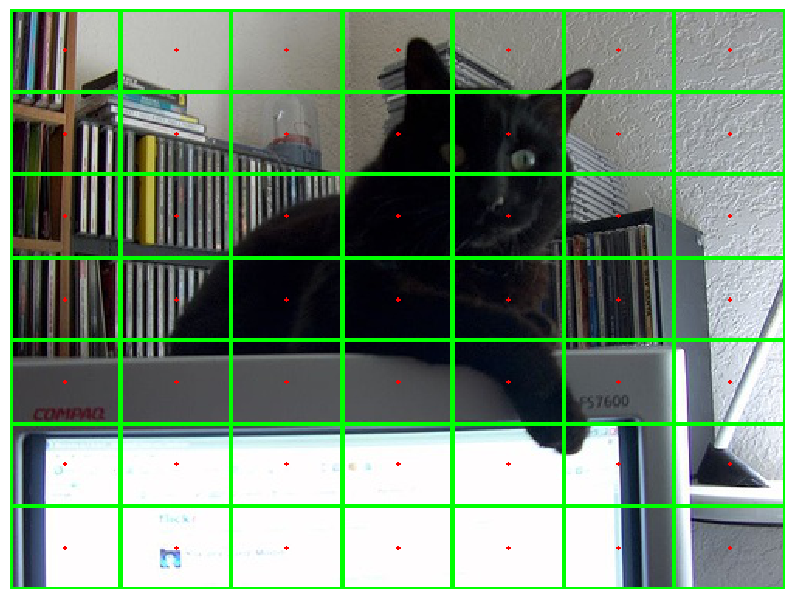

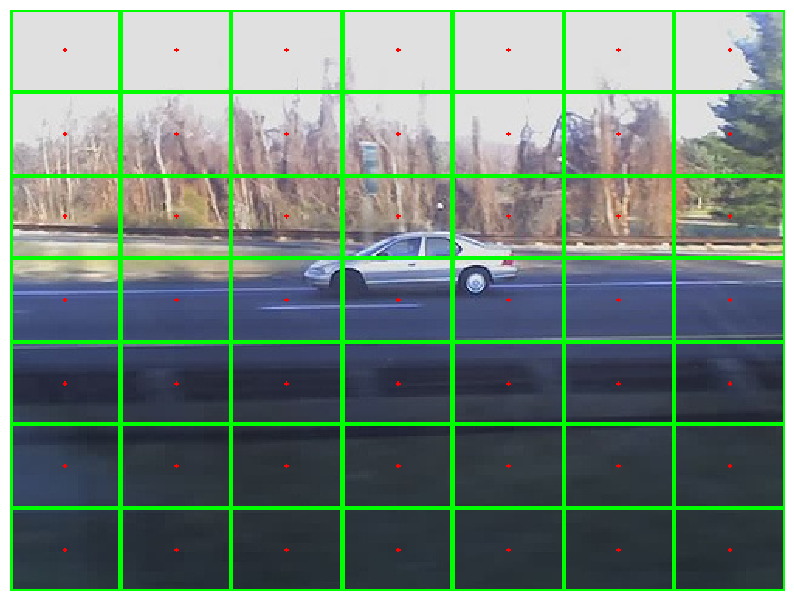

In [ ]:
# visualization
# simply create an activation grid where the cells are in green and the centers in red
# you should see the entire image divided by a 7x7 grid, with no gaps on the edges

grid_list = GenerateGrid(w_list.shape[0])

center = torch.cat((grid_list, grid_list), dim=-1)
grid_cell = center.clone()
grid_cell[:, :, :, [0, 1]] -= 1. / 2.
grid_cell[:, :, :, [2, 3]] += 1. / 2.
center = coord_trans(center, w_list, h_list)
grid_cell = coord_trans(grid_cell, w_list, h_list)

for img, anc, grid in zip(img_list, center, grid_cell):
  data_visualizer(img, idx_to_class, anc.reshape(-1, 4), grid.reshape(-1, 4))

In [ ]:
def GenerateProposal(grids, offsets):
    """
    Proposal generator.

    Inputs:
    - grids: Activation grids, of shape (B, H', W', 2). Grid centers are 
    represented by their coordinates in the activation map.
    - offsets: Transformations obtained from the Prediction Network 
    of shape (B, A, H', W', 4) that will be used to generate proposals region 
    proposals. The transformation offsets[b, a, h, w] = (tx, ty, tw, th) will be 
    applied to the grids[b, h, w]. 
    Assume that tx and ty are in the range
    (-0.5, 0.5) and h,w are normalized and thus in the range (0, 1).

    Outputs:
    - proposals: Region proposals of shape (B, A, H', W', 4), represented by the
    coordinates of their top-left and bottom-right corners. Using the
    transform offsets[b, a, h, w] and girds[b, a, h, w] should give the proposals.
    The expected parametrization of the proposals is (xtl, ytl, xbr, ybr). 

    CAUTION: 
    Notice that the offsets here are parametrized as (x, y, w, h). 
    The proposals you return need to be of the form (xtl, ytl, xbr, ybr).
    """
    proposals = None

    #############################################################################
    # TODO: Given grid coordinates and the proposed offset for each bounding    #
    # box, compute the proposal coordinates using the transformation formulas   #
    # above.                                                                    #
    #############################################################################
    # 1. Follow the formulas above to convert the grid centers into proposals.

    B, A, H, W, _ = offsets.shape
    grids = torch.repeat_interleave(grids[:, np.newaxis, :, :, :].clone(), A, 1)
    proposals_p = torch.zeros_like(offsets.clone())
    offsets = offsets.clone()

    proposals_p[:,:,:,:,0] = grids[:,:,:,:,0] + offsets[:,:,:,:,0]
    proposals_p[:,:,:,:,1] = grids[:,:,:,:,1] + offsets[:,:,:,:,1]
    proposals_p[:,:,:,:,2] = offsets[:,:,:,:,2] * 7
    proposals_p[:,:,:,:,3] = offsets[:,:,:,:,3] * 7

    # 2. Convert the proposals into (xtl, ytl, xbr, ybr) coordinate format as 
    # mentioned in the header and in the cell above that.

    proposals = torch.zeros_like(proposals_p)

    proposals[:,:,:,:,0] = proposals_p[:,:,:,:,0] - proposals_p[:,:,:,:,2] / 2
    proposals[:,:,:,:,1] = proposals_p[:,:,:,:,1] - proposals_p[:,:,:,:,3] / 2
    proposals[:,:,:,:,2] = proposals_p[:,:,:,:,0] + proposals_p[:,:,:,:,2] / 2
    proposals[:,:,:,:,3] = proposals_p[:,:,:,:,1] + proposals_p[:,:,:,:,3] / 2

    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################                        

    return proposals

In [ ]:
def IoU(proposals, bboxes):
    """
    Compute intersection over union between sets of bounding boxes.

    Inputs:
    - proposals: Proposals of shape (B, A, H', W', 4). These should be parametrized
    as (xtl, ytl, xbr, ybr).
    - bboxes: Ground-truth boxes from the DataLoader of shape (B, N, 5).
    Each ground-truth box is represented as tuple (x_tl, y_tl, x_br, y_br, class).
    If image i has fewer than N boxes, then bboxes[i] will be padded with extra
    rows of -1.

    Outputs:
    - iou_mat: IoU matrix of shape (B, A*H'*W', N) where iou_mat[b, i, n] gives
    the IoU between one element of proposals[b] and bboxes[b, n].

    For this implementation you DO NOT need to filter invalid proposals or boxes;
    in particular you don't need any special handling for bboxxes that are padded
    with -1.
    """
    iou_mat = None 

    #############################################################################
    # TODO: Compute the Intersection over Union (IoU) on proposals and GT boxes.#
    # No need to filter invalid proposals/bboxes (i.e., allow region area <= 0).#
    # However, you need to make sure to compute the IoU correctly (it should be #
    # 0 in those cases.                                                         # 
    # You need to ensure your implementation is efficient (no for loops).       #
    # HINT:                                                                     #
    # IoU = Area of Intersection / Area of Union, where                         #
    # Area of Union = Area of Proposal + Area of BBox - Area of Intersection    #
    # and the Area of Intersection can be computed using the top-left corner and#
    # bottom-right corner of proposal and bbox. Think about their relationships.#
    #############################################################################
    B, A, H, W, _ = proposals.shape
    N = bboxes.shape[1]
    proposals = proposals.reshape(B, A * H * W, 4).clone()
    proposals = torch.repeat_interleave(proposals[:, :, np.newaxis, :], N, 2)
    bboxes = bboxes.clone()
    bbox_prop = bboxes.unsqueeze(1)

    xtl = torch.max(proposals[:,:,:,0], bbox_prop[:,:,:,0])
    ytl = torch.max(proposals[:,:,:,1], bbox_prop[:,:,:,1])
    xbr = torch.min(proposals[:,:,:,2], bbox_prop[:,:,:,2])
    ybr = torch.min(proposals[:,:,:,3], bbox_prop[:,:,:,3])

    intersection = torch.clamp(xbr - xtl, min=0) * torch.clamp(ybr - ytl, min=0)
    proposal_area = (proposals[:,:,:,2] - proposals[:,:,:,0]) * (proposals[:,:,:,3] - proposals[:,:,:,1])
    bbox_area = (bbox_prop[:,:,:,2] - bbox_prop[:,:,:,0]) * (bbox_prop[:,:,:,3] - bbox_prop[:,:,:,1])

    iou_mat = intersection / (proposal_area + bbox_area - intersection)
    #############################################################################
    #                              END OF YOUR CODE                             #
    #############################################################################

    return iou_mat

In [ ]:
@torch.no_grad()
def rel_error(pred, true, eps=1e-8):
    """
    Returns relative error: (|pred| - |true|) / |true|
    Inputs:
    - pred: A torch tensor of the prediction of the true tensor
    - true: A torch tensor of the true tensor
    - eps: Small epsilon for numerical stability
    Returns:
    - Relative error between pred and true in floating point
    """
    return ((pred-true).abs() / true.abs().clamp(min=eps)).max().item()


In [ ]:
# simple sanity check

width, height = torch.tensor([35, 35], **to_float), torch.tensor([40, 40], **to_float)
sample_bbox = torch.tensor([[[1,1,11,11,0], [20,20,30,30,0]]], **to_float)
sample_proposals = torch.tensor([[[[[5,5,15,15], [27,27,37,37]]]]], **to_float)

result = IoU(sample_proposals, sample_bbox)

# check 1
expected_result = torch.tensor([[[0.21951219, 0.00000000],
                                 [0.00000000, 0.04712042]]], **to_float)
print('simple iou_mat error: ', rel_error(expected_result, result))

# # simple sanity check

# width, height = torch.tensor([35, 35], **to_float_cuda), torch.tensor([40, 40], **to_float_cuda)
# sample_bbox = torch.tensor([[[1,1,11,11,0], [20,20,30,30,0]]], **to_float_cuda)
# sample_proposals = torch.tensor([[[[[5,5,15,15], [27,27,37,37]]]]], **to_float_cuda)

# result = IoU(sample_proposals, sample_bbox)

# # check 1
# expected_result = torch.tensor([[[0.21951219, 0.00000000],
#                                  [0.00000000, 0.04712042]]], **to_float_cuda)
# print('simple iou_mat error: ', rel_error(expected_result, result))


simple iou_mat error:  0.0


In [ ]:
class PredictionNetwork(nn.Module):
    def __init__(self, in_dim, hidden_dim=128, num_bboxes=2, num_classes=20, drop_ratio=0.3):
        super().__init__()

        assert(num_classes != 0 and num_bboxes != 0)
        self.num_classes = num_classes
        self.num_bboxes = num_bboxes

        # Here we set up a network that will predict outputs for all bounding boxes.
        # This network has a 1x1 convolution layer with `hidden_dim` filters, 
        # followed by a Dropout layer with `p=drop_ratio`, a Leaky ReLU 
        # nonlinearity, and finally another 1x1 convolution layer to predict all
        # outputs. The network is stored in `self.net`, and has shape 
        # (B, 5*A+C, 7, 7), where the 5 predictions are in the order 
        # (x, y, w, h, conf_score), with A = `self.num_bboxes`
        # and C = `self.num_classes`.                                 

        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.drop_ratio = drop_ratio
        out_dim = 5*self.num_bboxes + self.num_classes

        layers = [
            torch.nn.Conv2d(self.in_dim, self.hidden_dim, kernel_size=1),
            torch.nn.Dropout(p=self.drop_ratio),
            torch.nn.LeakyReLU(negative_slope=0.2),
            torch.nn.Conv2d(self.hidden_dim,out_dim,kernel_size=1),
        ]
        self.net = nn.Sequential(*layers)

    def forward(self, features):
        """
        Run the forward pass of the network to predict outputs given features
        from the backbone network.

        Inputs:
        - features: Tensor of shape (B, in_dim, 7, 7) giving image features computed
          by the backbone network.

        Outputs:
        - bbox_xywh: Tensor of shape (B, A, 4, H, W) giving predicted offsets for 
          all bounding boxes.
        - conf_scores: Tensor of shape (B, A, H, W) giving predicted classification
          scores for all bounding boxes.
        - cls_scores: Tensor of shape (B, C, H, W) giving classification scores for
          each spatial position.
        """
        bbox_xywh, conf_scores, cls_scores = None, None, None

        ###########################################################################
        # TODO: Implement the forward pass of the PredictionNetwork.              #
        # - Use features to predict bbox_xywh (offsets), conf_scores, and         #
        # class_scores.                                                           #
        # - Make sure conf_scores is between 0 and 1 by squashing the             #
        # network output with a sigmoid.                                          #
        # - The first two elements t^x and t^y of offsets should be between -0.5  #
        # and 0.5. You can achieve this by squashing with a sigmoid               #
        # and subtracting 0.5.                                                    #
        # - The last two elements of bbox_xywh w and h should be normalized,      #
        # i.e. squashed with a sigmoid between 0 and 1.                           #
        #                                                                         #
        # Note: In the 5A+C dimension, the first 5*A would be bounding box        # 
        # offsets, and next C will be class scores.                               #
        ###########################################################################
        predictions = self.net(features)

        offsets_conf = predictions[:,:5 * self.num_bboxes,:,:]
        B, _, H, W = offsets_conf.shape
        offsets_conf = offsets_conf.reshape(B, self.num_bboxes, 5, H, W)

        bbox_xywh = torch.zeros_like(offsets_conf[:,:,0:4,:,:])
        bbox_xywh[:,:,0:2,:,:] = torch.sigmoid(offsets_conf[:,:,0:2,:,:].clone()) - 0.5
        bbox_xywh[:,:,2:4,:,:] = torch.sigmoid(offsets_conf[:,:,2:4,:,:].clone())

        conf_scores = torch.sigmoid(offsets_conf[:,:,4,:,:].clone())

        cls_scores = predictions[:,5 * self.num_bboxes:,:,:].clone()

        ###########################################################################
        #                              END OF YOUR CODE                           #
        ###########################################################################


        # You can uncomment these lines when training for a few iterations to 
        # check if your offets are within the expected bounds.

        # print("Checking offset bounds in Prediction Network...")

        # assert bbox_xywh[:, :, 0:2].max() <= 0.5 and bbox_xywh[:, :, 0:2].min() >= -0.5, 'invalid offsets (x, y) values'
        # assert bbox_xywh[:, :, 2:4].max() <= 1 and bbox_xywh[:, :, 2:4].min() >= 0, 'invalid offsets (w, h) values'
        # print("Check passed!")

        return bbox_xywh, conf_scores, cls_scores

In [ ]:
def ReferenceOnActivatedBboxes(bboxes, gt_bboxes, grid, iou_mat, pos_thresh=0.7, neg_thresh=0.3):
    """
    Determine the activated (positive) and negative bboxes for model training.

    A grid cell is responsible for predicting a GT box if the center of
    the box falls into that cell.
    Implementation details: First compute manhattan distance between grid cell centers
    (BxH’xW’) and GT box centers (BxN). This gives us a matrix of shape Bx(H'xW')xN and
    perform torch.min(dim=1)[1] on it gives us the indexes indicating activated grids
    responsible for GT boxes (convert to x and y). Among all the bboxes associated with
    the activate grids, the bbox with the largest IoU with the GT box is responsible to
    predict (regress to) the GT box.
    Note: One bbox might match multiple GT boxes.

    Main steps include:
    i) Decide activated and negative bboxes based on the IoU matrix.
    ii) Compute GT confidence score/offsets/object class on the positive proposals.
    iii) Compute GT confidence score on the negative proposals.

    Inputs:
    - bboxes: Bounding boxes, of shape BxAxH’xW’x4
    - gt_bboxes: GT boxes of shape BxNx5, where N is the number of PADDED GT boxes,
            5 indicates (x_{lr}^{gt}, y_{lr}^{gt}, x_{rb}^{gt}, y_{rb}^{gt}) and class index
    - grid (float): A cell grid of shape BxH'xW'x2 where 2 indicate the (x, y) coord
    - iou_mat: IoU matrix of shape Bx(AxH’xW’)xN
    - pos_thresh: Positive threshold value
    - neg_thresh: Negative threshold value

    Outputs:
    - activated_anc_ind: Index on activated bboxes, of shape M, where M indicates the 
                       number of activated bboxes
    - negative_anc_ind: Index on negative bboxes, of shape M
    - GT_conf_scores: GT IoU confidence scores on activated bboxes, of shape M
    - GT_offsets: GT offsets on activated bboxes, of shape Mx4. They are denoted as
                \hat{t^x}, \hat{t^y}, \hat{t^w}, \hat{t^h} in the formulation earlier.
    - GT_class: GT class category on activated bboxes, essentially indexed from gt_bboxes[:, :, 4],
              of shape M
    - activated_anc_coord: Coordinates on activated bboxes (mainly for visualization purposes)
    - negative_anc_coord: Coordinates on negative bboxes (mainly for visualization purposes)
    """


    B, A, h_amap, w_amap, _ = bboxes.shape
    N = gt_bboxes.shape[1]

    # activated/positive bboxes
    max_iou_per_anc, max_iou_per_anc_ind = iou_mat.max(dim=-1)

    bbox_mask = (gt_bboxes[:, :, 0] != -1) # BxN, indicate invalid boxes
    bbox_centers = (gt_bboxes[:, :, 2:4] - gt_bboxes[:, :, :2]) / 2. + gt_bboxes[:, :, :2] # BxNx2

    mah_dist = torch.abs(grid.view(B, -1, 2).unsqueeze(2) - bbox_centers.unsqueeze(1)).sum(dim=-1) # Bx(H'xW')xN
    min_mah_dist = mah_dist.min(dim=1, keepdim=True)[0] # Bx1xN
    grid_mask = (mah_dist == min_mah_dist).unsqueeze(1) # Bx1x(H'xW')xN

    reshaped_iou_mat = iou_mat.view(B, A, -1, N)
    anc_with_largest_iou = reshaped_iou_mat.max(dim=1, keepdim=True)[0] # Bx1x(H’xW’)xN
    anc_mask = (anc_with_largest_iou == reshaped_iou_mat) # BxAx(H’xW’)xN
    activated_anc_mask = (grid_mask & anc_mask).view(B, -1, N)
    activated_anc_mask &= bbox_mask.unsqueeze(1)

    # one bbox could match multiple GT boxes
    activated_anc_ind = torch.nonzero(activated_anc_mask.view(-1)).squeeze(-1)
    GT_conf_scores = iou_mat.view(-1)[activated_anc_ind]
    gt_bboxes = gt_bboxes.view(B, 1, N, 5).repeat(1, A*h_amap*w_amap, 1, 1).view(-1, 5)[activated_anc_ind]
    GT_class = gt_bboxes[:, 4].long()
    gt_bboxes = gt_bboxes[:, :4]
    activated_anc_ind = (activated_anc_ind.float() / activated_anc_mask.shape[-1]).long()

    print('number of pos proposals: ', activated_anc_ind.shape[0])

    activated_anc_coord = bboxes.reshape(-1, 4)[activated_anc_ind]

    activated_grid_coord = grid.repeat(1,A,1,1,1).reshape(-1, 2)[activated_anc_ind]


    # GT offsets

    # bbox are x_tl, y_tl, x_br, y_br
    # offsets are t_x, t_y, t_w, t_h

    # Grid: (B, H, W, 2) -> This will be used to calculate center offsets
    # w, h offsets are not offsets but normalized w,h themselves.

    wh_offsets = torch.sqrt((gt_bboxes[:, 2:4] - gt_bboxes[:, :2])/7.)
    assert torch.max((gt_bboxes[:, 2:4] - gt_bboxes[:, :2])/7.) <= 1, "w and h targets not normalised, should be between 0 and 1"

    xy_offsets = (gt_bboxes[:, :2] + gt_bboxes[:, 2:4])/(2.) - activated_grid_coord

    assert torch.max(torch.abs(xy_offsets)) <= 0.5, \
    "x and y offsets should be between -0.5 and 0.5! Got {}".format( \
    torch.max(torch.abs(xy_offsets)))

    GT_offsets = torch.cat((xy_offsets, wh_offsets), dim=-1)

    # negative bboxes
    negative_anc_mask = (max_iou_per_anc < neg_thresh) # Bx(AxH’xW’)
    negative_anc_ind = torch.nonzero(negative_anc_mask.view(-1)).squeeze(-1)
    negative_anc_ind = negative_anc_ind[torch.randint(0, negative_anc_ind.shape[0], (activated_anc_ind.shape[0],))]
    negative_anc_coord = bboxes.reshape(-1, 4)[negative_anc_ind.view(-1)]

    # activated_anc_coord and negative_anc_coord are mainly for visualization purposes
    return activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, \
         activated_anc_coord, negative_anc_coord

In [ ]:
def ConfScoreRegression(conf_scores, GT_conf_scores):
    """
    Use sum-squared error as in YOLO

    Inputs:
    - conf_scores: Predicted confidence scores
    - GT_conf_scores: GT confidence scores

    Outputs:
    - conf_score_loss
    """
    # the target conf_scores for negative samples are zeros
    GT_conf_scores = torch.cat((torch.ones_like(GT_conf_scores), \
                              torch.zeros_like(GT_conf_scores)), dim=0).view(-1, 1)

    conf_score_loss = torch.sum((conf_scores - GT_conf_scores)**2) * 1. / GT_conf_scores.shape[0]
    return conf_score_loss

In [ ]:
def BboxRegression(offsets, GT_offsets):
    """"
    Use sum-squared error as in YOLO
    For both xy and wh.
    NOTE: In YOLOv1, the authors use sqrt(w) and sqrt(h) for normalized w and h
    (read paper for more details) and thus both offsets and GT_offsets will 
    be having (x, y, sqrt(w), sqrt(h)) parametrization of the coodinates. 


    Inputs:
    - offsets: Predicted box offsets
    - GT_offsets: GT box offsets

    Outputs:
    - bbox_reg_loss
    """

    bbox_reg_loss = torch.sum((offsets - GT_offsets)**2) * 1. / GT_offsets.shape[0]
    return bbox_reg_loss

In [ ]:
def ObjectClassification(class_prob, GT_class, batch_size, anc_per_img, activated_anc_ind):
    """"
    Use softmax loss

    Inputs:
    - class_prob: Predicted class logits
    - GT_class: GT box class label
    - batch_size: the batch size to compute loss over
    - anc_per_img: anchor indices for each image
    - activated_anc_ind: indices for positive anchors

    Outputs:
    - object_cls_loss, the classification loss for object detection
    """
    # average within sample and then average across batch
    # such that the class pred would not bias towards dense popular objects like `person`

    all_loss = F.cross_entropy(class_prob, GT_class, reduction='none') # , reduction='sum') * 1. / batch_size
    object_cls_loss = 0
    for idx in range(batch_size):
        anc_ind_in_img = (activated_anc_ind >= idx * anc_per_img) & (activated_anc_ind < (idx+1) * anc_per_img)
        object_cls_loss += all_loss[anc_ind_in_img].sum() * 1. / torch.sum(anc_ind_in_img)
    object_cls_loss /= batch_size
    # object_cls_loss = F.cross_entropy(class_prob, GT_class, reduction='sum') * 1. / batch_size

    return object_cls_loss

In [ ]:
class SingleStageDetector(nn.Module):
    def __init__(self):
        super().__init__()

        self.feat_extractor = FeatureExtractor()
        self.num_classes = 20
        self.num_bboxes = 2
        self.pred_network = PredictionNetwork(1280, num_bboxes=2, \
                                              num_classes=self.num_classes)


    def forward(self, images, bboxes):
        """
        Training-time forward pass for the single-stage detector.

        Inputs:
        - images: Input images, of shape (B, 3, 224, 224)
        - bboxes: GT bounding boxes of shape (B, N, 5) (padded)

        Outputs:
        - total_loss: Torch scalar giving the total loss for the batch.
        """
        # weights to multiple to each loss term
        w_conf = 1 # for conf_scores
        w_reg = 1 # for offsets
        w_cls = 1 # for class_prob

        total_loss = None             

        # 1. Feature extraction
        features = self.feat_extractor(images)

        # 2. Grid generator
        grid_list = GenerateGrid(images.shape[0])

        # 3. Prediction Network
        bbox_xywh, conf_scores, cls_scores = self.pred_network(features)
        # (B, A, 4, H, W), (B, A, H, W), (B, C, H, W)

        B, A, _, H, W = bbox_xywh.shape
        bbox_xywh = bbox_xywh.permute(0, 1, 3, 4, 2) # (B, A, H, W, 4)

        assert bbox_xywh.max() <= 1 and bbox_xywh.min() >= -0.5, 'invalid offsets values'

        # 4. Calculate the proposals
        proposals = GenerateProposal(grid_list, bbox_xywh)

        # 5. Compute IoU
        iou_mat = IoU(proposals, bboxes)

        # 7. Using the activated_anc_ind, select the activated conf_scores, bbox_xywh, cls_scores
        activated_anc_ind, negative_anc_ind, GT_conf_scores, GT_offsets, GT_class, _, _ \
          = ReferenceOnActivatedBboxes(bbox_xywh, bboxes, grid_list, iou_mat, neg_thresh=0.3)

        conf_scores = conf_scores.view(B, A, 1, H, W)
        pos = self._extract_bbox_data(conf_scores, activated_anc_ind)
        neg = self._extract_bbox_data(conf_scores, negative_anc_ind)
        conf_scores = torch.cat([pos, neg], dim = 0)

        # 6. The loss function
        bbox_xywh[:, :, :, :, 2:4] = torch.sqrt(bbox_xywh[:, :, :, :, 2:4])

        # assert bbox_xywh[:, :, :, :, :2].max() <= 0.5 and bbox_xywh[:, :, :, :, :2].min() >= -0.5, 'invalid offsets values'
        # assert bbox_xywh[:, :, :, :, :2:4].max() <= 1 and bbox_xywh[:, :, :, :, 2:4].min() >= 0, 'invalid offsets values'

        offsets = self._extract_bbox_data(bbox_xywh.permute(0, 1, 4, 2, 3), activated_anc_ind)
        cls_scores = self._extract_class_scores(cls_scores, activated_anc_ind)
        anc_per_img = torch.prod(torch.tensor(bbox_xywh.shape[1:-1])) # use as argument in ObjectClassification
        ###########################################################################
        # TODO: Compute conf_loss, reg_loss, cls_loss, total_loss using the       #
        # functions defined in part (e).                                           #
        # - total_loss is the sum of the three other losses.                      #                                                                
        ###########################################################################
        # 8. Compute losses

        conf_loss = ConfScoreRegression(conf_scores, GT_conf_scores)
        reg_loss = BboxRegression(offsets, GT_offsets)
        cls_loss = ObjectClassification(cls_scores, GT_class, B, anc_per_img, activated_anc_ind)

        total_loss = w_conf * conf_loss + w_reg * reg_loss + w_cls * cls_loss

        ###########################################################################
        #                            END OF YOUR CODE                             #
        ###########################################################################

        print('(weighted) conf loss: {:.4f}, reg loss: {:.4f}, cls loss: {:.4f}'.format(conf_loss, reg_loss, cls_loss))

        return total_loss

    def inference(self):
        raise NotImplementedError

    def _extract_bbox_data(self, bbox_data, bbox_idx):
        """
        Inputs:
        - bbox_data: Tensor of shape (B, A, D, H, W) giving a vector of length
          D for each of A bboxes at each point in an H x W grid.
        - bbox_idx: int64 Tensor of shape (M,) giving bbox indices to extract

        Returns:
        - extracted_bboxes: Tensor of shape (M, D) giving bbox data for each
          of the bboxes specified by bbox_idx.
        """
        B, A, D, H, W = bbox_data.shape
        bbox_data = bbox_data.permute(0, 1, 3, 4, 2).contiguous().view(-1, D)
        extracted_bboxes = bbox_data[bbox_idx]
        return extracted_bboxes

    def _extract_class_scores(self, all_scores, bbox_idx):
        """
        Inputs:
        - all_scores: Tensor of shape (B, C, H, W) giving classification scores for
          C classes at each point in an H x W grid.
        - bbox_idx: int64 Tensor of shape (M,) giving the indices of bboxes at
          which to extract classification scores

        Returns:
        - extracted_scores: Tensor of shape (M, C) giving the classification scores
          for each of the bboxes specified by bbox_idx.
        """
        B, C, H, W = all_scores.shape
        A = self.num_bboxes
        all_scores = all_scores.contiguous().permute(0, 2, 3, 1).contiguous()
        all_scores = all_scores.view(B, 1, H, W, C).expand(B, A, H, W, C)
        all_scores = all_scores.reshape(B * A * H * W, C)
        extracted_scores = all_scores[bbox_idx]
        return extracted_scores


In [ ]:
def DetectionSolver(detector, train_loader, learning_rate=3e-3,
            lr_decay=1, num_epochs=20, **kwargs):
    """
    Run optimization to train the model.
    """

    # ship model to GPU
#     detector.to(**to_float_cuda)
    detector.to(**to_float)

    # optimizer setup
    from torch import optim
    # optimizer = optim.Adam(
    optimizer = optim.SGD(
    filter(lambda p: p.requires_grad, detector.parameters()),
    learning_rate) # leave betas and eps by default
    lr_scheduler = optim.lr_scheduler.LambdaLR(optimizer,
                                             lambda epoch: lr_decay ** epoch)

    # sample minibatch data
    loss_history = []
    detector.train()
    for i in range(num_epochs):
        start_t = time.time()
        for iter_num, data_batch in enumerate(train_loader):
            images, boxes, w_batch, h_batch, _ = data_batch
            resized_boxes = coord_trans(boxes, w_batch, h_batch, mode='p2a')
            # print(resized_boxes)
#             images = images.to(**to_float_cuda)
#             resized_boxes = resized_boxes.to(**to_float_cuda)
            images = images.to(**to_float)
            resized_boxes = resized_boxes.to(**to_float)

            loss = detector(images, resized_boxes)
            optimizer.zero_grad()
            loss.backward()
            loss_history.append(loss.item())
            optimizer.step()

            print('(Iter {} / {})'.format(iter_num, len(train_loader)))

        end_t = time.time()
        print('(Epoch {} / {}) loss: {:.4f} time per epoch: {:.1f}s'.format(
            i, num_epochs, loss.item(), end_t-start_t))

    lr_scheduler.step()

    # plot the training losses
    plt.plot(loss_history)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Training loss history')
    plt.show()

    return loss_history

lr:  0.01
number of pos proposals:  43
(weighted) conf loss: 0.2693, reg loss: 0.3371, cls loss: 3.3145
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.2670, reg loss: 0.3108, cls loss: 2.2827
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.2543, reg loss: 0.2861, cls loss: 1.5952
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.2394, reg loss: 0.2786, cls loss: 1.0881
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.2312, reg loss: 0.2573, cls loss: 0.8699
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.2187, reg loss: 0.2308, cls loss: 0.7494
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.2149, reg loss: 0.2091, cls loss: 0.5390
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1937, reg loss: 0.2130, cls loss: 0.4918
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1987, reg loss: 0.2029, cls loss: 0.4692
(Iter 0 / 1)
number of pos proposals:  4

(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1455, reg loss: 0.0681, cls loss: 0.0435
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1290, reg loss: 0.0664, cls loss: 0.0447
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1171, reg loss: 0.0871, cls loss: 0.0415
(Iter 0 / 1)
number of pos proposals:  44
(weighted) conf loss: 0.1211, reg loss: 0.0827, cls loss: 0.0453
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1638, reg loss: 0.0910, cls loss: 0.0385
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1385, reg loss: 0.0750, cls loss: 0.0480
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1121, reg loss: 0.0851, cls loss: 0.0409
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1002, reg loss: 0.0660, cls loss: 0.0439
(Iter 0 / 1)
number of pos proposals:  44
(weighted) conf loss: 0.1279, reg loss: 0.0673, cls loss: 0.0355
(Iter 0 / 1)
number of pos proposals:

(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.0687, reg loss: 0.0484, cls loss: 0.0276
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.0682, reg loss: 0.0634, cls loss: 0.0676
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.0409, reg loss: 0.0636, cls loss: 0.0401
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.1039, reg loss: 0.0512, cls loss: 0.0252
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.0596, reg loss: 0.0503, cls loss: 0.0294
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.0518, reg loss: 0.0533, cls loss: 0.0326
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.0497, reg loss: 0.0477, cls loss: 0.0325
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.0830, reg loss: 0.0691, cls loss: 0.0283
(Iter 0 / 1)
number of pos proposals:  43
(weighted) conf loss: 0.0542, reg loss: 0.0460, cls loss: 0.0347
(Iter 0 / 1)
number of pos proposals:

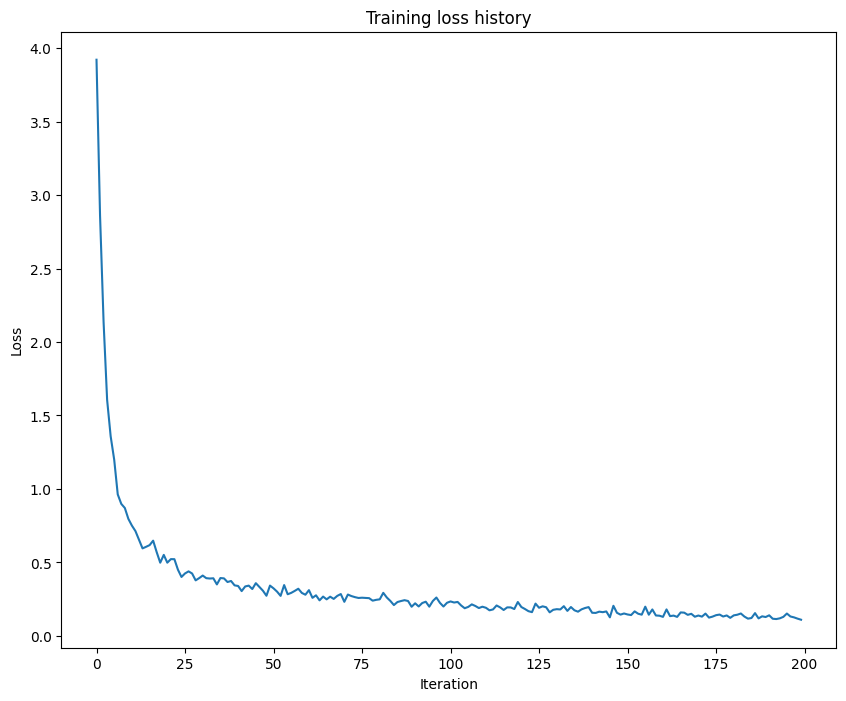

In [ ]:
# monitor the training loss
fix_random_seed(0)
num_sample = 10
small_dataset = torch.utils.data.Subset(train_dataset, torch.linspace(0, len(train_dataset)-1, steps=num_sample).long())
small_train_loader = pascal_voc2007_loader(small_dataset, 10) # a new loader

for lr in [1e-2]:
    print('lr: ', lr)
    detector = SingleStageDetector()
    loss_history_overfit = DetectionSolver(detector, small_train_loader, learning_rate=lr, num_epochs=200)

Final loss obtained after overfitting is: 0.1104


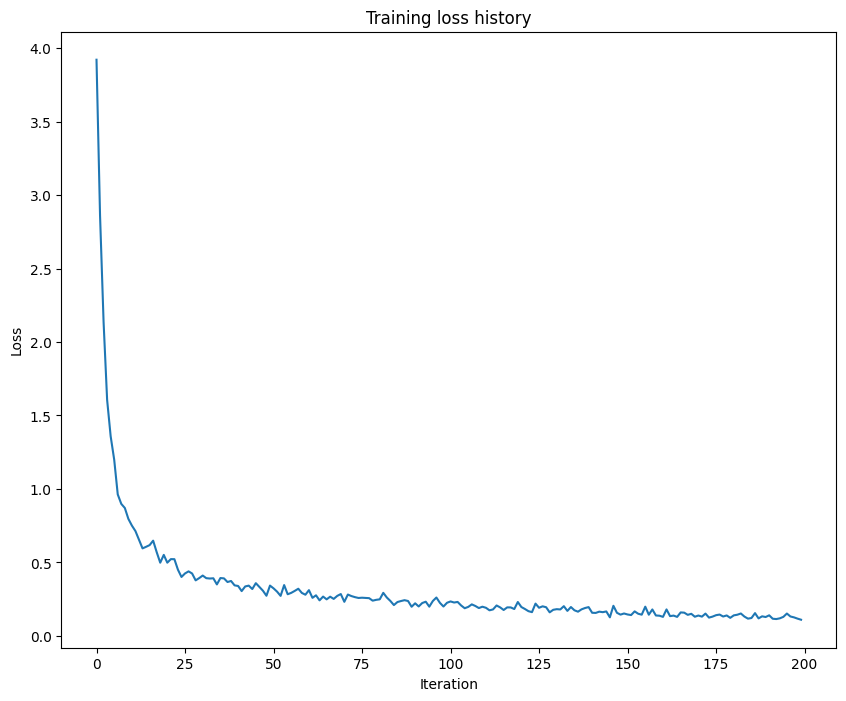

In [ ]:
print('Final loss obtained after overfitting is: %.4f' %(loss_history_overfit[-1]))
plt.plot(loss_history_overfit)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
# monitor the training loss
train_loader = pascal_voc2007_loader(train_dataset, 100) # a new loader

lr = 5e-2
num_epochs = 50
yolo_detector = SingleStageDetector()
loss_history_train = DetectionSolver(yolo_detector, train_loader, learning_rate=lr, num_epochs=num_epochs)

number of pos proposals:  283
(weighted) conf loss: 0.2638, reg loss: 0.2893, cls loss: 3.1847
(Iter 0 / 25)
number of pos proposals:  367
(weighted) conf loss: 0.2433, reg loss: 0.2983, cls loss: 2.6802
(Iter 1 / 25)
number of pos proposals:  298
(weighted) conf loss: 0.2429, reg loss: 0.2646, cls loss: 2.6436
(Iter 2 / 25)
number of pos proposals:  297
(weighted) conf loss: 0.2466, reg loss: 0.2721, cls loss: 2.3640
(Iter 3 / 25)
number of pos proposals:  298
(weighted) conf loss: 0.2391, reg loss: 0.2650, cls loss: 2.3350
(Iter 4 / 25)
number of pos proposals:  258
(weighted) conf loss: 0.2326, reg loss: 0.2599, cls loss: 2.2032
(Iter 5 / 25)
number of pos proposals:  329
(weighted) conf loss: 0.2345, reg loss: 0.2555, cls loss: 2.2053
(Iter 6 / 25)
number of pos proposals:  332
(weighted) conf loss: 0.2212, reg loss: 0.2424, cls loss: 2.0855
(Iter 7 / 25)
number of pos proposals:  303
(weighted) conf loss: 0.2361, reg loss: 0.2482, cls loss: 1.8236
(Iter 8 / 25)
number of pos propo

(Iter 23 / 25)
number of pos proposals:  366
(weighted) conf loss: 0.1201, reg loss: 0.2093, cls loss: 0.5540
(Iter 24 / 25)
(Epoch 2 / 50) loss: 0.8833 time per epoch: 620.1s
number of pos proposals:  285
(weighted) conf loss: 0.1196, reg loss: 0.1995, cls loss: 0.5615
(Iter 0 / 25)
number of pos proposals:  372
(weighted) conf loss: 0.1271, reg loss: 0.2113, cls loss: 0.6006
(Iter 1 / 25)
number of pos proposals:  298
(weighted) conf loss: 0.1315, reg loss: 0.2198, cls loss: 0.4681
(Iter 2 / 25)
number of pos proposals:  303
(weighted) conf loss: 0.1360, reg loss: 0.2112, cls loss: 0.5113
(Iter 3 / 25)
number of pos proposals:  307
(weighted) conf loss: 0.1395, reg loss: 0.2157, cls loss: 0.4957
(Iter 4 / 25)
number of pos proposals:  259
(weighted) conf loss: 0.1273, reg loss: 0.2235, cls loss: 0.4322
(Iter 5 / 25)
number of pos proposals:  332
(weighted) conf loss: 0.1299, reg loss: 0.2196, cls loss: 0.4318
(Iter 6 / 25)
number of pos proposals:  338
(weighted) conf loss: 0.1178, r

In [ ]:
print('Final loss obtained after training is: %.4f' %(loss_history_train[-1]))
plt.plot(loss_history_train)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.show()

In [ ]:
# (optional) load/save checkpoint
torch.save(yolo_detector.state_dict(), 'yolo_detector.pt') # uncomment to save your checkpoint
# yolo_detector.load_state_dict(torch.load('yolo_detector.pt')) # uncomment to load your previous checkpoint

In [ ]:
def nms(boxes, scores, iou_threshold=0.5, topk=None):
    """
    Non-maximum suppression removes overlapping bounding boxes.

    Inputs:
    - boxes: top-left and bottom-right coordinate values of the bounding boxes
    to perform NMS on, of shape Nx4
    - scores: scores for each one of the boxes, of shape N
    - iou_threshold: discards all overlapping boxes with IoU > iou_threshold; float
    - topk: If this is not None, then return only the topk highest-scoring boxes.
    Otherwise if this is None, then return all boxes that pass NMS.

    Outputs:
    - keep: torch.long tensor with the indices of the elements that have been
    kept by NMS, sorted in decreasing order of scores; of shape [num_kept_boxes]
    """

    if (not boxes.numel()) or (not scores.numel()):
    return torch.zeros(0, dtype=torch.long)

    keep = None
    #############################################################################
    # TODO: Implement non-maximum suppression which iterates the following:     #
    #       1. Select the highest-scoring box among the remaining ones,         #
    #          which has not been chosen in this step before                    #
    #       2. Eliminate boxes with IoU > threshold                             #
    #       3. If any boxes remain, GOTO 1                                      #
    #       Your implementation should not depend on a specific device type;    #
    #       you can use the device of the input if necessary.                   #
    #############################################################################
    keep = []
    idxs = torch.argsort(scores, descending=True)

    while (len(idxs) > 0):
    idx = idxs[0];
    keep.append(idx)
    if topk and len(keep) == topk:
        return torch.tensor(keep).long()
    curr_xtl, curr_ytl, curr_xbr, curr_ybr = boxes[idx]
    xtl = torch.max(curr_xtl, boxes[idxs][:, 0])
    ytl = torch.max(curr_ytl, boxes[idxs][:, 1])
    xbr = torch.min(curr_xbr, boxes[idxs][:, 2])
    ybr = torch.min(curr_ybr, boxes[idxs][:, 3])

    intersection = torch.clamp(xbr - xtl, min=0) * torch.clamp(ybr - ytl, min=0)
    area_curr = torch.tensor([(curr_xbr - curr_xtl) * (curr_ybr - curr_ytl)]).unsqueeze(1)
    area_remain = (boxes[idxs][:, 2] - boxes[idxs][:, 0]) * (boxes[idxs][:, 3] - boxes[idxs][:, 1])
    iou_mat = intersection / (area_curr + area_remain - intersection)

    thresholds = iou_mat <= iou_threshold
    idxs = idxs[thresholds.squeeze(0)]
    keep = torch.tensor(keep).long()

    #############################################################################
    #                               END OF YOUR CODE                            #
    #############################################################################

    return keep

In [ ]:
def detector_inference(self, images, thresh=0.5, nms_thresh=0.7):
    """"
    Inference-time forward pass for the single stage detector.

    Inputs:
    - images: Input images
    - thresh: Threshold value on confidence scores
    - nms_thresh: Threshold value on NMS

    Outputs:
    - final_propsals: Keeped proposals after confidence score thresholding and NMS,
                      a list of B (*x4) tensors
    - final_conf_scores: Corresponding confidence scores, a list of B (*x1) tensors
    - final_class: Corresponding class predictions, a list of B  (*x1) tensors
    """
    final_proposals, final_conf_scores, final_class = [], [], []

    # Predicting the final proposal coordinates `final_proposals`,         
    # confidence scores `final_conf_scores`, and the class index `final_class`.  
    
    # The overall steps are similar to the forward pass but now we do not need  
    # to decide the activated nor negative bounding boxes.                         
    # We threshold the conf_scores based on the threshold value `thresh`.  
    # Then, apply NMS (torchvision.ops.nms) to the filtered proposals given the  
    # threshold `nms_thresh`.                                                    
    # The class index is determined by the class with the maximal probability.   
    # Note that `final_propsals`, `final_conf_scores`, and `final_class` are all 
    # lists of B 2-D tensors.

    with torch.no_grad():
        # Feature extraction
        features = self.feat_extractor(images)

        # Grid  Generator
        grid_list = GenerateGrid(images.shape[0])

        # Prediction Network
        offsets, conf_scores, class_scores = self.pred_network(features)
        B, A, _, w_amap, h_amap = offsets.shape # B, A, 4, H, W
        C = self.num_classes
        conf_scores = conf_scores.view(B, -1) # B, A*H*W
        offsets = offsets.permute(0, 1, 3, 4, 2) # B, A, H, W, 4
        class_scores = class_scores.permute(0, 2, 3, 1).reshape(B, -1, C) # B, H*W, C

        most_conf_class_score, most_conf_class_idx = class_scores.max(dim=-1)

        # Proposal generator
        proposals = GenerateProposal(grid_list, offsets).reshape(B, -1, 4) # Bx(AxH'xW')x4
        # proposals = GenerateProposal(grid_list, offsets).reshape(B, -1, 4) # Bx(AxH'xW')x4
        # Thresholding and NMS
        for i in range(B):
            score_mask = torch.nonzero((conf_scores[i] > thresh)).squeeze(1) # (AxH'xW')
            prop_before_nms = proposals[i, score_mask]
            scores_before_nms = conf_scores[i, score_mask]
            class_idx_before_nms = most_conf_class_idx[i, score_mask%(h_amap*w_amap)]
            # class_prob_before_nms = most_conf_class_prob[i, score_mask/A]

        prop_keep = torchvision.ops.nms(prop_before_nms, scores_before_nms, nms_thresh).to(images.device)
        final_proposals.append(prop_before_nms[prop_keep])
        final_conf_scores.append(scores_before_nms[prop_keep].unsqueeze(-1))
        final_class.append(class_idx_before_nms[prop_keep].unsqueeze(-1))

    return final_proposals, final_conf_scores, final_class
SingleStageDetector.inference = detector_inference

In [ ]:
def DetectionInference(detector, data_loader, dataset, idx_to_class, thresh=0.8, nms_thresh=0.3, output_dir=None):

    # ship model to GPU
    detector.to(**to_float_cuda)

    detector.eval()
    start_t = time.time()

    if output_dir is not None:
        det_dir = 'mAP/input/detection-results'
        gt_dir = 'mAP/input/ground-truth'
        if os.path.exists(det_dir):
            shutil.rmtree(det_dir)
        os.mkdir(det_dir)
        if os.path.exists(gt_dir):
            shutil.rmtree(gt_dir)
        os.mkdir(gt_dir)

    for iter_num, data_batch in enumerate(data_loader):
        images, boxes, w_batch, h_batch, img_ids = data_batch
        images = images.to(**to_float_cuda)

        final_proposals, final_conf_scores, final_class = detector.inference(images, thresh=thresh, nms_thresh=nms_thresh)

        # clamp on the proposal coordinates
        batch_size = len(images)
        for idx in range(batch_size):
            torch.clamp_(final_proposals[idx][:, 0::2], min=0, max=w_batch[idx])
            torch.clamp_(final_proposals[idx][:, 1::2], min=0, max=h_batch[idx])

            # visualization
            # get the original image
            # hack to get the original image so we don't have to load from local again...
            i = batch_size*iter_num + idx
            img, _ = dataset.__getitem__(i)

            valid_box = sum([1 if j != -1 else 0 for j in boxes[idx][:, 0]])
            final_all = torch.cat((final_proposals[idx], \
            final_class[idx].float(), final_conf_scores[idx]), dim=-1).cpu()
            resized_proposals = coord_trans(final_all, w_batch[idx], h_batch[idx])


            # write results to file for evaluation (use mAP API https://github.com/Cartucho/mAP for now...)
            if output_dir is not None:
            file_name = img_ids[idx].replace('.jpg', '.txt')
            with open(os.path.join(det_dir, file_name), 'w') as f_det, \
              open(os.path.join(gt_dir, file_name), 'w') as f_gt:
                print('{}: {} GT bboxes and {} proposals'.format(img_ids[idx], valid_box, resized_proposals.shape[0]))
                for b in boxes[idx][:valid_box]:
                f_gt.write('{} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[0], b[1], b[2], b[3]))
                for b in resized_proposals:
                f_det.write('{} {:.6f} {:.2f} {:.2f} {:.2f} {:.2f}\n'.format(idx_to_class[b[4].item()], b[5], b[0], b[1], b[2], b[3]))
            else:
                data_visualizer(img, idx_to_class, boxes[idx][:valid_box], resized_proposals)

    end_t = time.time()
    print('Total inference time: {:.1f}s'.format(end_t-start_t))

In [ ]:
# visualize the output from the overfitted model on small dataset
# the bounding boxes should be really accurate
DetectionInference(detector, small_train_loader, small_dataset, idx_to_class, thresh=0.8)

In [ ]:
# visualize the same output from the model trained on the entire training set
# some bounding boxes might not make sense
DetectionInference(yolo_detector, small_train_loader, small_dataset, idx_to_class)

In [ ]:
DetectionInference(yolo_detector, val_loader, val_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3)
# DetectionInference(yolo_detector, train_loader, train_dataset, idx_to_class, output_dir='mAP/input', thresh=0.8, nms_thresh=0.3) # uncomment to see training mAP
!cd mAP && python main.py